In [1]:
%load_ext pypath_magic
%pypath -a /home/vlad/projects/datamanagers/daily/

UsageError: '/home/vlad/projects/datamanagers/daily' is already in the user path.


In [110]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm

rng = np.random.default_rng()

# sklearn imports
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV


from daily.datamanager import DailyDataManager
import plotter.activate
from plotter import plot
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
ddm = DailyDataManager()
df = ddm.get_data('fx_rates')
rets = df.pct_change()
rets = rets.loc[rets.isnull().sum(1) == 0]
rets = rets.fillna(0)

### distribution analysis

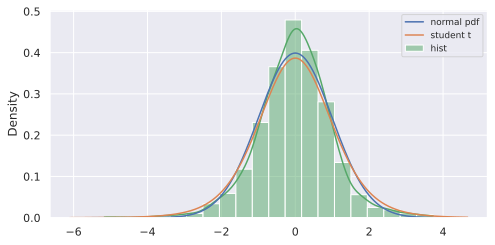

In [16]:
vals = rets['AUD'].values/rets['AUD'].std()
with plot(legend_outside=False) as p:
    sns.histplot(vals, bins=20, ax=p.ax(), kde=True, label='hist', stat='density', color='g');
    plotter.plot_func(sp.stats.norm.pdf, ax=p.ax(), label='normal pdf');
    plotter.plot_func(lambda x: sp.stats.t.pdf(x, df=8), ax=p.ax(), label='student t');

We have heavy tails on q-q plot but the hist above is misleading, since heavier tails may std higher : should we clip say by -2, 2 and calculated std based on that values (mb compare to smth similar for normal law between -2, 2, and take ratio)??

Return distributions typically have more weight near zero that t-student, so that they look more like normal around 0, but then have heavy tails instead of normal tails.

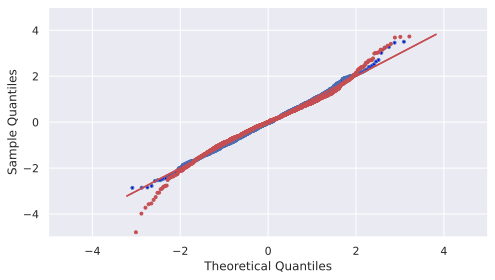

In [91]:
t_sample = sp.stats.t.rvs(df=15, size=1000)

with plot(8, legend=False) as p:
    sm.qqplot(t_sample, line='45', ax=p.ax(), markersize=3, label='t-student');
    sm.qqplot(vals, line='45', ax=p.ax(), markerfacecolor='r', markeredgecolor='r', markersize=3, label='returns');
    p.ax().set_xlim((-5, 5))
    p.ax().set_ylim((-5, 5))

In [14]:
sp.stats.kurtosis(vals), sp.stats.skew(vals)

(1.8651067828190921, -0.13539845582311422)

Theory: student-t density, properties, kurtosis and skewness, effects, q-q plot shapes;


In [17]:
sp.stats.normaltest(vals)

NormaltestResult(statistic=73.26657400329526, pvalue=1.2313048814251535e-16)

## OLS, hypothesis testing

In [20]:
x = rets.drop('SEK', axis=1)
y = rets['SEK']

sm_ols_fit = sm.OLS(y, x).fit()
ftest_ccy = ['CAD', 'JPY']
idx = np.vectorize(x.columns.get_loc)(ftest_ccy)
r_matrix = np.eye(len(x.columns))[idx, :]
sm_ols_fit.f_test(r_matrix), sm_ols_fit.fvalue

(<class 'statsmodels.stats.contrast.ContrastResults'>
 <F test: F=array([[1.32559471]]), p=0.26595124659051184, df_denom=1.52e+03, df_num=2>,
 425.59225772819747)

### F-distribution

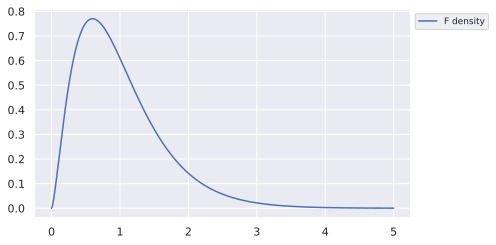

In [21]:

# f.pdf(x, dfn, dfd)    dfn is p2-p1 (small), dfd is n-p2 (big number), typical values are F(5, 300)

with plot() as p:
    xvals = inp.linspace(0, 5, 1000)
    p.ax().plot(xvals, sp.stats.f.pdf(xvals, dfn=5, dfd=len(x)-7), label='F density')

### Chow test

0.9998841132730267


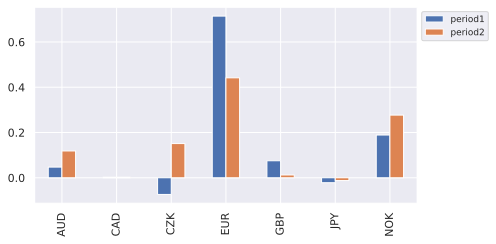

In [67]:
from sklearn import model_selection
x1, x2, y1, y2 = model_selection.train_test_split(x, y, train_size=0.5, shuffle=False)

coefs1 = sm.OLS(y1, x1).fit().params
coefs2 = sm.OLS(y2, x2).fit().params

with plot(legend_labels=['period1', 'period2']) as p:
    pd.concat([coefs1, coefs2], keys=[1, 2], axis=1).plot.bar(ax=p.ax())
    
rss1 = sm.OLS(y1, x1).fit().ssr
rss2 = sm.OLS(y2, x2).fit().ssr
rss = sm.OLS(y, x).fit().ssr

chow_stat = (rss - (rss1+rss2))*(len(x)-2*7)/(7*(rss1 + rss2))
print(sp.stats.f.cdf(chow_stat, 7, len(x) - 14))

In [ ]:
# r_matrix to use to test if all coefs in a block are equal (will be F-test)
np.eye(5) - np.eye(5, k=1)

In [68]:
# t-test
res = sm.OLS(y, x).fit()
res.t_test(r_matrix=(x.columns=='AUD').astype(int) - (x.columns=='CZK').astype(int))

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0322      0.041     -0.788      0.431      -0.112       0.048

## look at this article https://stats.idre.ucla.edu/sas/faq/how-can-i-compare-regression-coefficients-across-three-or-more-groups/ to check if the coefs are equal across groups;  looks like different version of ANOVA and F-test indeed help to solve all similar problems! develop more intuition!

In [146]:
sp.stats.norm.ppf(0.975)

1.959963984540054

### ANOVA

In [69]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
cars_df = pd.read_csv("https://raw.githubusercontent.com/focods/WonderfulML/master/data/mtcars.csv")
m01 = ols('mpg ~ am + wt', data=cars_df).fit()
m02 = ols('mpg ~ am + wt + am:wt', data=cars_df).fit()
anovaResults = anova_lm(m01, m02, m02)
print(anovaResults)

   df_resid         ssr  df_diff    ss_diff         F    Pr(>F)
0      29.0  278.319697      0.0        NaN       NaN       NaN
1      28.0  188.007666      1.0  90.312031  13.45018  0.001017
2      28.0  188.007666     -0.0  -0.000000       NaN       NaN


### Boostrap and confidence intervals

In [102]:
bootstrap_sample = rng.choice(vals, len(vals), replace=True)

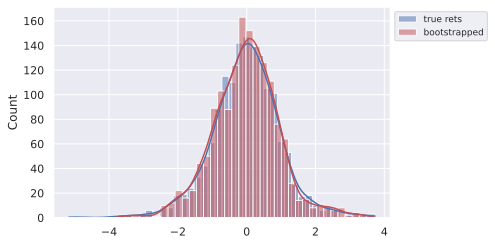

In [106]:
# real and bootstrap sample distributions
with plot() as p:
    sns.histplot(vals, kde=True, ax=p.ax(), label='true rets', alpha=0.5)
    sns.histplot(bootstrap_sample, kde=True, ax=p.ax(), label='bootstrapped', color='r', alpha=0.5)

In [125]:
def resample(x, y):
    idx = rng.choice(range(len(x)), size=len(x))
    return x.iloc[idx].copy(), y.iloc[idx].copy()

nsamples = 100
coef_sample = [RidgeCV(fit_intercept=False).fit(*resample(x, y)).coef_ for i in range(nsamples)]

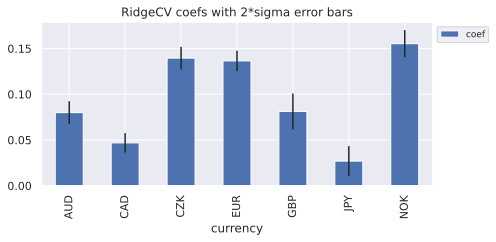

In [130]:
def process_coef_sample(coef_sample):
    coef_sample = pd.DataFrame(coef_sample)
    coef_sample.columns = x.columns
    coef_sample.index.name = 'sample_num'
    return coef_sample

coef_sample = process_coef_sample(coef_sample)

with plot(title='RidgeCV coefs with 2*sigma error bars') as p:
    coef_sample.mean(0).plot.bar(yerr=2*coef_sample.std(0), label='coef')

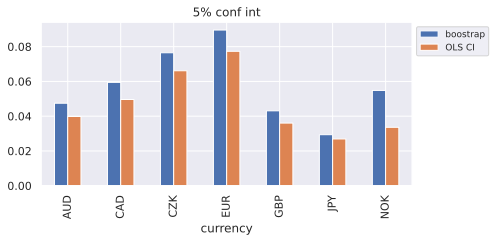

In [160]:
nsamples = 500
coef_sample = [LinearRegression(fit_intercept=False).fit(*resample(x, y)).coef_ for i in range(nsamples)]
coef_sample = process_coef_sample(coef_sample)

fit_res = sm.OLS(y, x).fit()
ci = fit_res.conf_int(alpha=0.05)

fctr = sp.stats.norm.ppf(1-0.05/2)

with plot(title='5% conf int') as p:
    pd.concat([(fctr*coef_sample.std(0)), ((ci[1]-ci[0])/2)], axis=1, keys=['boostrap', 'OLS CI']).plot.bar(ax=p.ax())
    
# What is the relation of bootstrap CIs to OLS CIs, why are they larger?

### MC-based confidence estimation
To use MC-based CI need to preserve dependence structure in the features. E.g. it's not correct to use random alternating signs just for one feature (since this will eliminate it's correlation with other features), would have to alternate signs for the whole model, or use other techniques.

How to check if adding a new feature significantly improves the model for non-OLS models (no ANOVA or F-tests)??

## Statistical estimation
most of necessary tools already available in scipy, no need to learn about sufficient statistics for each distribution

In [30]:
# beta distribution
data = sp.stats.beta.rvs(5,2,loc=0,scale=1,size=5000)
sp.stats.beta.fit(data)

(4.640522638308054,
 1.9018758532958757,
 0.022727103168103193,
 0.9761566820124292)

In [36]:
# fit normal distribution
data = sp.stats.norm.rvs(10.0, 2.5, size=500)
sp.stats.norm.fit(data)

(9.942044492404069, 2.3873709472150235)

In [40]:
# t-student
data = sp.stats.t.rvs(df=3, loc=0, scale=1, size=500)
sp.stats.t.fit(data)

(3.073837951881968, 0.013695606043723794, 1.046612101559478)

Explore about tools for general MLE estimation for a sequence of variables (maybe just the same, send data for scipy distribution fit method), explore fitting MLE estimation on sample distribution and not theoretical one